In [162]:
# Package imports

# Basics
import numpy as np
import pandas as pd

# Visualization
from plotnine import *
import plotnine as p9
import matplotlib.pyplot as plt

# General ML
import sklearn
from sklearn.pipeline import Pipeline

# Splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Machine learning regression algorithms 
from sklearn.linear_model import LinearRegression as LR
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RF

# Model Interpretation
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance
from pdpbox import pdp

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
# Data import
df = pd.read_csv("../Data/GeneratedData/Cleaned_Data_Restricted.csv", index_col = "Unnamed: 0")
df.sample(5)

,Country,Life_Satisfaction,Diag_Account,EDI,Suffrage,GDPpc,Ineq_Frac
528,Georgia,4.101837,0.839,0.480,100.0,8443.436089,10.574317
718,Italy,6.853784,0.964,0.854,100.0,34872.126607,5.824896
1292,Serbia,5.101840,0.746,0.601,100.0,12764.000000,10.691495
917,Malaysia,5.384702,0.524,0.302,100.0,17430.444562,15.096874
216,Burkina Faso,4.035561,0.914,0.549,100.0,1326.197517,108.558116


In [3]:
len(df)

1546

In [97]:
# Imputed data import
df_I = pd.read_csv("../Data/GeneratedData/Cleaned_Data_Imputed.csv", index_col = "Unnamed: 0").drop(["Avg_Hours_Worked", "Mean_Earnings"], axis = 1)
df_I.sample(5)

,Country,Life_Satisfaction,EDI,Suffrage,Diag_Account,AFI,GDPpc,U_Coverage,Ineq_Frac,Min_Wage,Gender_Pay_Gap,Percent_Low_Income_Female
955,Mauritania,3.922664,0.457,100.0,0.747,0.974788,3424.000000,24.598948,26.634732,867.338061,-139.486319,10.537748
1559,Ukraine,4.803954,0.569,100.0,0.860,0.626000,9355.987925,19.024419,7.618014,79.210000,-105.594001,20.104253
30,Angola,4.360250,0.311,100.0,0.449,0.992220,8190.000000,23.344407,32.958229,866.341690,-118.660475,18.181306
930,Mali,4.313017,0.337,100.0,0.887,0.956810,1448.000000,20.985365,23.624315,55.740000,-163.876595,7.424160
938,Malta,5.773875,0.815,100.0,0.926,0.922000,23632.624639,52.200000,4.537735,874.870000,-1.601441,42.945393


In [98]:
len(df_I)

1696

In [6]:
# Unon data import
df_U = pd.read_csv("../Data/GeneratedData/Cleaned_Data_Union.csv", index_col = "Unnamed: 0")
df_U.sample(5)

,Country,Life_Satisfaction,Diag_Account,EDI,Suffrage,GDPpc,U_Coverage,Ineq_Frac
302,China,4.846295,0.296,0.102,100.0,8190.112095,30.4,40.287986
862,Lithuania,5.466921,0.924,0.836,100.0,17983.349042,10.0,8.937682
206,Bulgaria,4.222297,0.898,0.702,100.0,15204.000000,11.4,5.487960
959,Mauritius,5.477073,0.931,0.842,100.0,16483.000000,25.2,12.726352
479,Estonia,5.628909,0.964,0.900,100.0,24493.000000,4.5,9.269509


In [7]:
len(df_U)

572

# Methods
In this notebook, I will set up a machine learning pipeline, run various models, assess their results, and interpret these results.

## Logging Variables
Before we get started, we're going to log both `GDPpc_2011_prices` and `Inequality_Frac`.

In [8]:
# Logs GDP per capita
df['GDPpc'] =  np.where(df['GDPpc']<=0,0,np.log(df['GDPpc']))
df_I['GDPpc'] =  np.where(df_I['GDPpc']<=0,0,np.log(df_I['GDPpc']))
df_U['GDPpc'] =  np.where(df_U['GDPpc']<=0,0,np.log(df_U['GDPpc']))

In [9]:
# Logs GDP per capita
df['Ineq_Frac'] =  np.where(df['Ineq_Frac']<=0,0,np.log(df['Ineq_Frac']))
df_I['Ineq_Frac'] =  np.where(df_I['Ineq_Frac']<=0,0,np.log(df_I['Ineq_Frac']))
df_U['Ineq_Frac'] =  np.where(df_U['Ineq_Frac']<=0,0,np.log(df_U['Ineq_Frac']))

# Pipeline

In [10]:
# K-Folds
fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)

In [11]:
# Initializes pipeline
pipe = Pipeline(steps=[('pre_process', StandardScaler()),('model',None)])

In [134]:
# Hyperparameter Tuning
search_space = [
    
    # Linear Regression
    {'model': [LR()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[1,2,3,4,5,10]},
    
    # Support Vector Machine for regression
    # Selected the rbf kernel based on the grid search of the imputed model
    {'model': [SVR()],
     'model__kernel':["rbf"],
     'model__tol':[0.01, 0.05, 0.1],
     'model__C':[3, 5, 7],
     'model__gamma':[0.25, 0.5, 1]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]}
    
]

## Restricted Data

In [13]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_root_mean_squared_error',
                      n_jobs=4)

In [14]:
y = df[['Life_Satisfaction']]
X = df.drop(columns=['Life_Satisfaction', "Country"])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

In [15]:
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', StandardScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(n_neighbors=3)],
                          'model__n_neighbors': [1, 2, 3, 4, 5, 10]},
                         {'model': [SVR()], 'model__C': [10, 20, 30, 40],
                          'model__gamma': [0.001, 0.01, 0.1, 1],
                          'model__kernel': ['rbf'],
                          'model__tol': [0.0001, 0.001, 0.01]},
                         {'model': [RandomForestRegressor()],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='neg_root_mean_squared_error')

## Imputed Data

In [135]:
search_I = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_root_mean_squared_error',
                      n_jobs=4)

In [136]:
y = df_I[['Life_Satisfaction']]
X = df_I.drop(columns=['Life_Satisfaction', "Country"])
train_X_I, test_X_I, train_y_I, test_y_I = train_test_split(X,y,test_size = .25,random_state=123)

In [137]:
search_I.fit(train_X_I,train_y_I)

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', StandardScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor()],
                          'model__n_neighbors': [1, 2, 3, 4, 5, 10]},
                         {'model': [SVR(C=5, gamma=0.5, tol=0.05)],
                          'model__C': [3, 5, 7], 'model__gamma': [0.25, 0.5, 1],
                          'model__kernel': ['rbf'],
                          'model__tol': [0.01, 0.05, 0.1]},
                         {'model': [RandomForestRegressor()],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='neg_root_mean_squared_error')

## Union Data

In [19]:
search_U = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_root_mean_squared_error',
                      n_jobs=4)

In [20]:
y = df_U[['Life_Satisfaction']]
X = df_U.drop(columns=['Life_Satisfaction', "Country"])
train_X_U, test_X_U, train_y_U, test_y_U = train_test_split(X,y,test_size = .25,random_state=123)

In [21]:
search_U.fit(train_X_U,train_y_U)

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', StandardScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(n_neighbors=2)],
                          'model__n_neighbors': [1, 2, 3, 4, 5, 10]},
                         {'model': [SVR()], 'model__C': [10, 20, 30, 40],
                          'model__gamma': [0.001, 0.01, 0.1, 1],
                          'model__kernel': ['rbf'],
                          'model__tol': [0.0001, 0.001, 0.01]},
                         {'model': [RandomForestRegressor()],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='neg_root_mean_squared_error')

# Results

## Restricted Data

In [22]:
search.best_score_

-0.47308890911206164

In [23]:
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=2), 'model__n_neighbors': 3}

In [24]:
knn_mod = search.best_estimator_

## Imputed Data

In [138]:
search_I.best_score_

-0.5027707584926

In [139]:
search_I.best_params_

{'model': SVR(C=5, gamma=0.5, tol=0.05),
 'model__C': 5,
 'model__gamma': 0.5,
 'model__kernel': 'rbf',
 'model__tol': 0.05}

In [140]:
knn_mod_I = search_I.best_estimator_

## Union Data

In [28]:
search_U.best_score_

-0.3802709203483963

In [29]:
search_U.best_params_

{'model': KNeighborsRegressor(n_neighbors=2), 'model__n_neighbors': 2}

In [30]:
knn_mod_U = search_U.best_estimator_

# Interpretation

## Restricted Data

### Variable Importance

In [163]:
vi = permutation_importance(knn_mod,train_X,train_y,n_repeats=25)

Organize the output as a data frame. 

In [164]:
# Rename columns for visualization
train_X = train_X.rename({"Diag_Account": "Diagonal Accounability",
                     "EDI": "Electoral Democracy Index", 
                     "Suffrage":"Percent of Adult Population with Suffrage", 
                     "GDPpc":"GDP per Capita (2011 Prices)", 
                     "Avg_Hours_Worked":"Average Hours Worked", 
                     "U_Coverage":"Percent of Workforce Unionized", 
                     "Ineq_Frac":"Fractional Inequality", 
                     "Ineq_Diff":"Differential Inequality", 
                     "AFI":"Academic Freedom Index",
                     "Democracy":"Democracy Binary"}, axis = 1)

# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)
vi_dat

,variable,vi,std,low,high
0,GDP per Capita (2011 Prices),0.835582,0.031248,0.773086,0.898078
1,Electoral Democracy Index,0.524750,0.021424,0.481903,0.567598
2,Fractional Inequality,0.409692,0.016954,0.375785,0.443600
3,Diagonal Accounability,0.307915,0.016150,0.275615,0.340215
4,Percent of Adult Population with Suffrage,0.043746,0.009956,0.023834,0.063658


### Visualizations

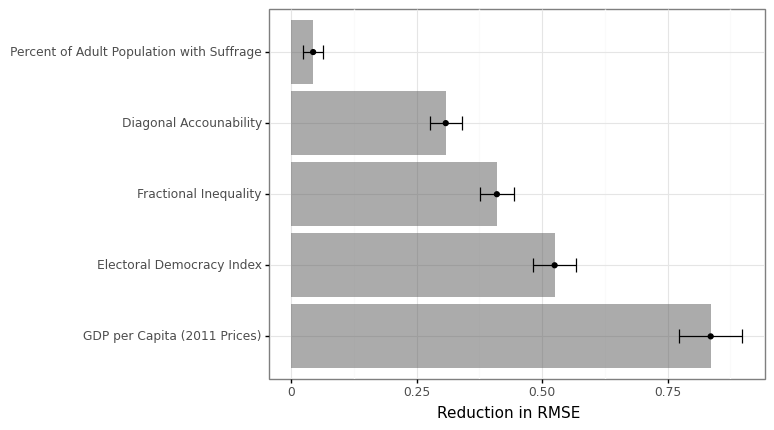

<ggplot: (109686964556)>

In [165]:
# Plot
p = ggplot(vi_dat, aes(x="variable",y="vi")) + geom_col(alpha=.5) + geom_point() + geom_errorbar(aes(ymin="low",ymax="high"),width=.2) + theme_bw() + scale_x_discrete(limits=vi_dat.variable.tolist()) + coord_flip() + labs(y="Reduction in RMSE",x="") # , title = "Feature Importances for KNN w/ Restricted Data"

p

In [166]:
p.save(filename = "Figures/FeatImp_Restricted.png", dpi = 300)

## Imputed Data

### Variable Importance

In [167]:
vi = permutation_importance(knn_mod_I,train_X_I,train_y_I,n_repeats=25)

Organize the output as a data frame. 

In [168]:
# Rename columns for visualization
train_X_I = train_X_I.rename({"Diag_Account": "Diagonal Accounability",
                     "EDI": "Electoral Democracy Index", 
                     "Suffrage":"Percent of Adult Population with Suffrage", 
                     "GDPpc":"GDP per Capita (2011 Prices)", 
                     "Avg_Hours_Worked":"Average Hours Worked", 
                     "U_Coverage":"Percent of Workforce Unionized", 
                     "Ineq_Frac":"Fractional Inequality", 
                     "Ineq_Diff":"Differential Inequality", 
                     "AFI":"Academic Freedom Index",
                     "Gender_Pay_Gap":"Gender Pay Gap (Female - Male)",
                     "Percent_Low_Income_Female":"Share of Female Low Income Earners",
                     "Democracy":"Democracy Binary"}, axis = 1)

# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X_I.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)
vi_dat

,variable,vi,std,low,high
0,Electoral Democracy Index,0.531601,0.021812,0.487977,0.575224
1,GDP per Capita (2011 Prices),0.425204,0.011843,0.401518,0.448890
2,Gender Pay Gap (Female - Male),0.381543,0.014184,0.353176,0.409911
3,Academic Freedom Index,0.303276,0.018742,0.265792,0.340760
4,Diagonal Accounability,0.286242,0.013235,0.259772,0.312712
5,Share of Female Low Income Earners,0.238676,0.009884,0.218908,0.258444
6,Min_Wage,0.217910,0.012085,0.193740,0.242080
7,Percent of Workforce Unionized,0.169841,0.009059,0.151723,0.187959
8,Fractional Inequality,0.120435,0.008313,0.103810,0.137060
9,Percent of Adult Population with Suffrage,0.023475,0.003474,0.016526,0.030423


### Visualizations

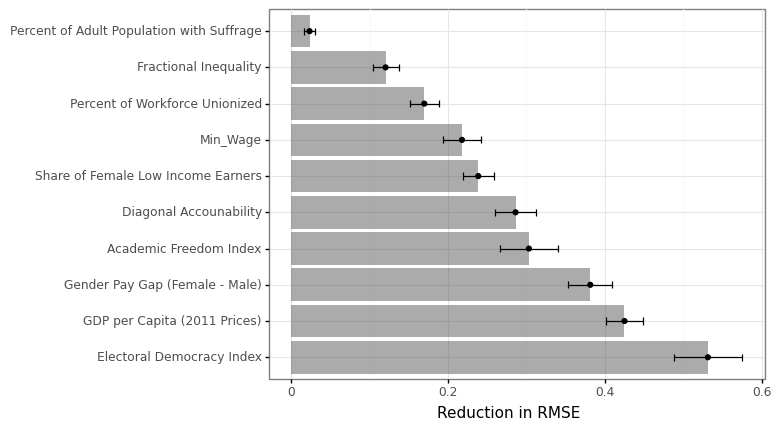

<ggplot: (109778622452)>

In [169]:
# Plot
p = ggplot(vi_dat, aes(x="variable",y="vi")) + geom_col(alpha=.5) + geom_point() + geom_errorbar(aes(ymin="low",ymax="high"),width=.2) + theme_bw() + scale_x_discrete(limits=vi_dat.variable.tolist()) + coord_flip() + labs(y="Reduction in RMSE",x="") #, title = "Feature Importances for SVC w/ Imputed Data"

p

In [170]:
p.save(filename = "Figures/FeatImp_Imputed.png", dpi = 300)

## Union Data

### Variable Importance

In [171]:
vi = permutation_importance(knn_mod_U,train_X_U,train_y_U,n_repeats=25)

Organize the output as a data frame. 

In [172]:
# Rename columns for visualization
train_X_U = train_X_U.rename({"Diag_Account": "Diagonal Accounability",
                     "EDI": "Electoral Democracy Index", 
                     "Suffrage":"Percent of Adult Population with Suffrage", 
                     "GDPpc":"GDP per Capita (2011 Prices)", 
                     "Avg_Hours_Worked":"Average Hours Worked", 
                     "U_Coverage":"Percent of Workforce Unionized", 
                     "Ineq_Frac":"Fractional Inequality", 
                     "Ineq_Diff":"Differential Inequality", 
                     "AFI":"Academic Freedom Index",
                     "Democracy":"Democracy Binary"}, axis = 1)

# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X_U.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)
vi_dat

,variable,vi,std,low,high
0,GDP per Capita (2011 Prices),0.807550,0.052938,0.701674,0.913426
1,Electoral Democracy Index,0.516354,0.032991,0.450372,0.582336
2,Fractional Inequality,0.463925,0.038168,0.387590,0.540261
3,Percent of Workforce Unionized,0.360927,0.028673,0.303580,0.418273
4,Diagonal Accounability,0.257535,0.019876,0.217783,0.297287
5,Percent of Adult Population with Suffrage,0.016745,0.008669,-0.000593,0.034084


### Visualizations

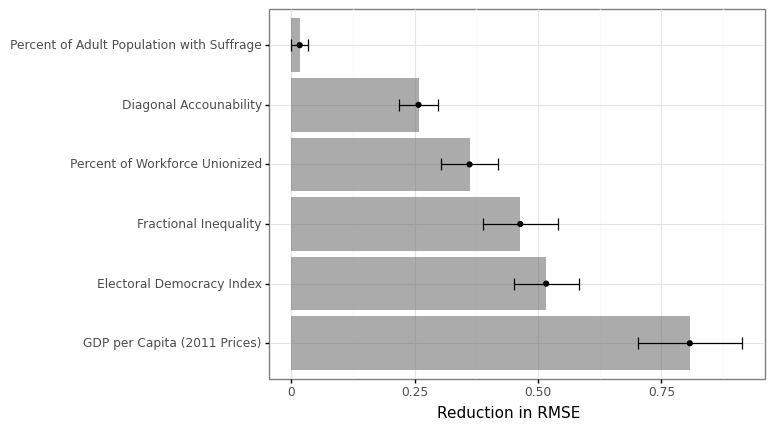

<ggplot: (109686380409)>

In [173]:
# Plot
p = ggplot(vi_dat, aes(x="variable",y="vi")) + geom_col(alpha=.5) + geom_point() + geom_errorbar(aes(ymin="low",ymax="high"),width=.2) + theme_bw() + scale_x_discrete(limits=vi_dat.variable.tolist()) + coord_flip() + labs(y="Reduction in RMSE",x="", title = "Feature Importances for KNN w/ the Union Data")

p

In [174]:
p.save(filename = "Figures/FeatImp_Union.png", dpi = 300)

# Learning Curves

Cross validation of the KNN model will be tested using learning curves

In [175]:
def LearningCurves(estimator, X, y):
    cv = ShuffleSplit(test_size=0.2, random_state=0)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv, n_jobs=-1, train_sizes = np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-',
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-',
             label="Cross-validation score")
    plt.xlabel("Training Set Size")
    plt.ylabel("Score (RMSE)")
    plt.legend(loc="best")
    plt.grid()

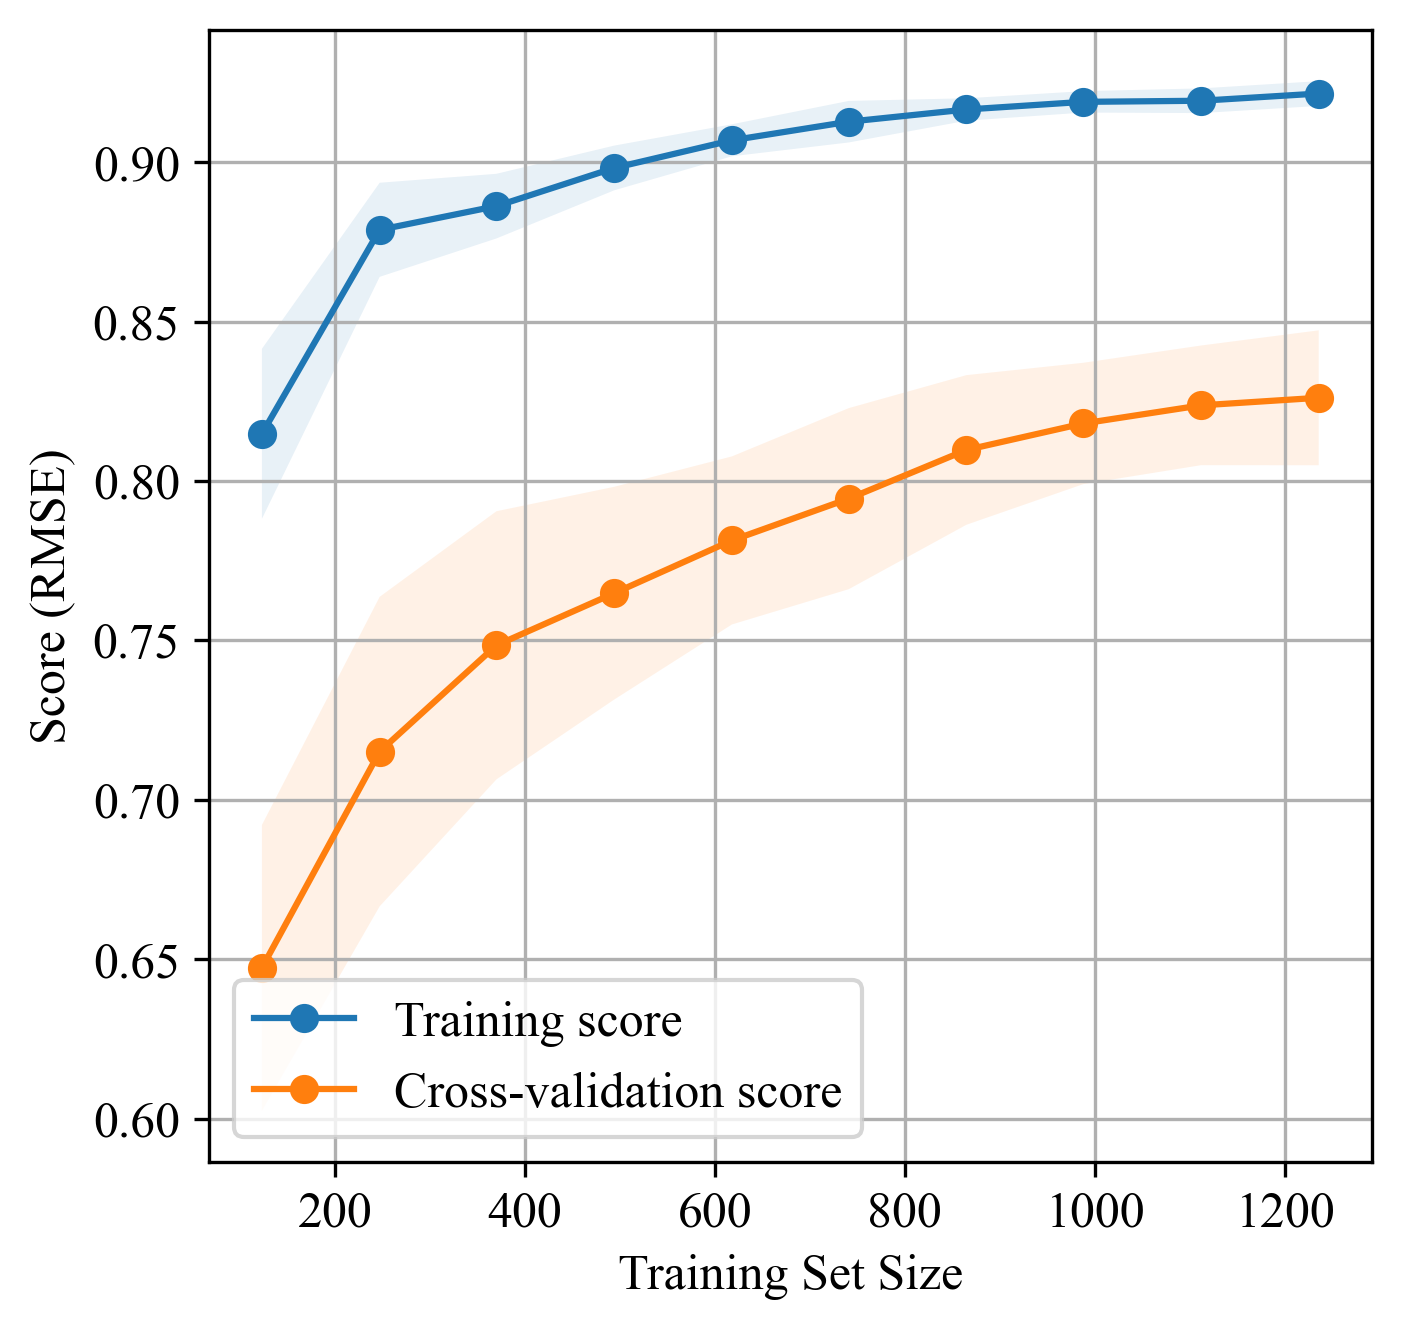

In [176]:
y = df[['Life_Satisfaction']]
X = df.drop(columns=['Life_Satisfaction', "Country"])
LearningCurves(knn_mod, X, y)
#plt.title("Learning Curve - KNN Model (Restricted Data)")
plt.savefig(fname = "Figures/LearnCurve_Restricted.png", dpi = 300)

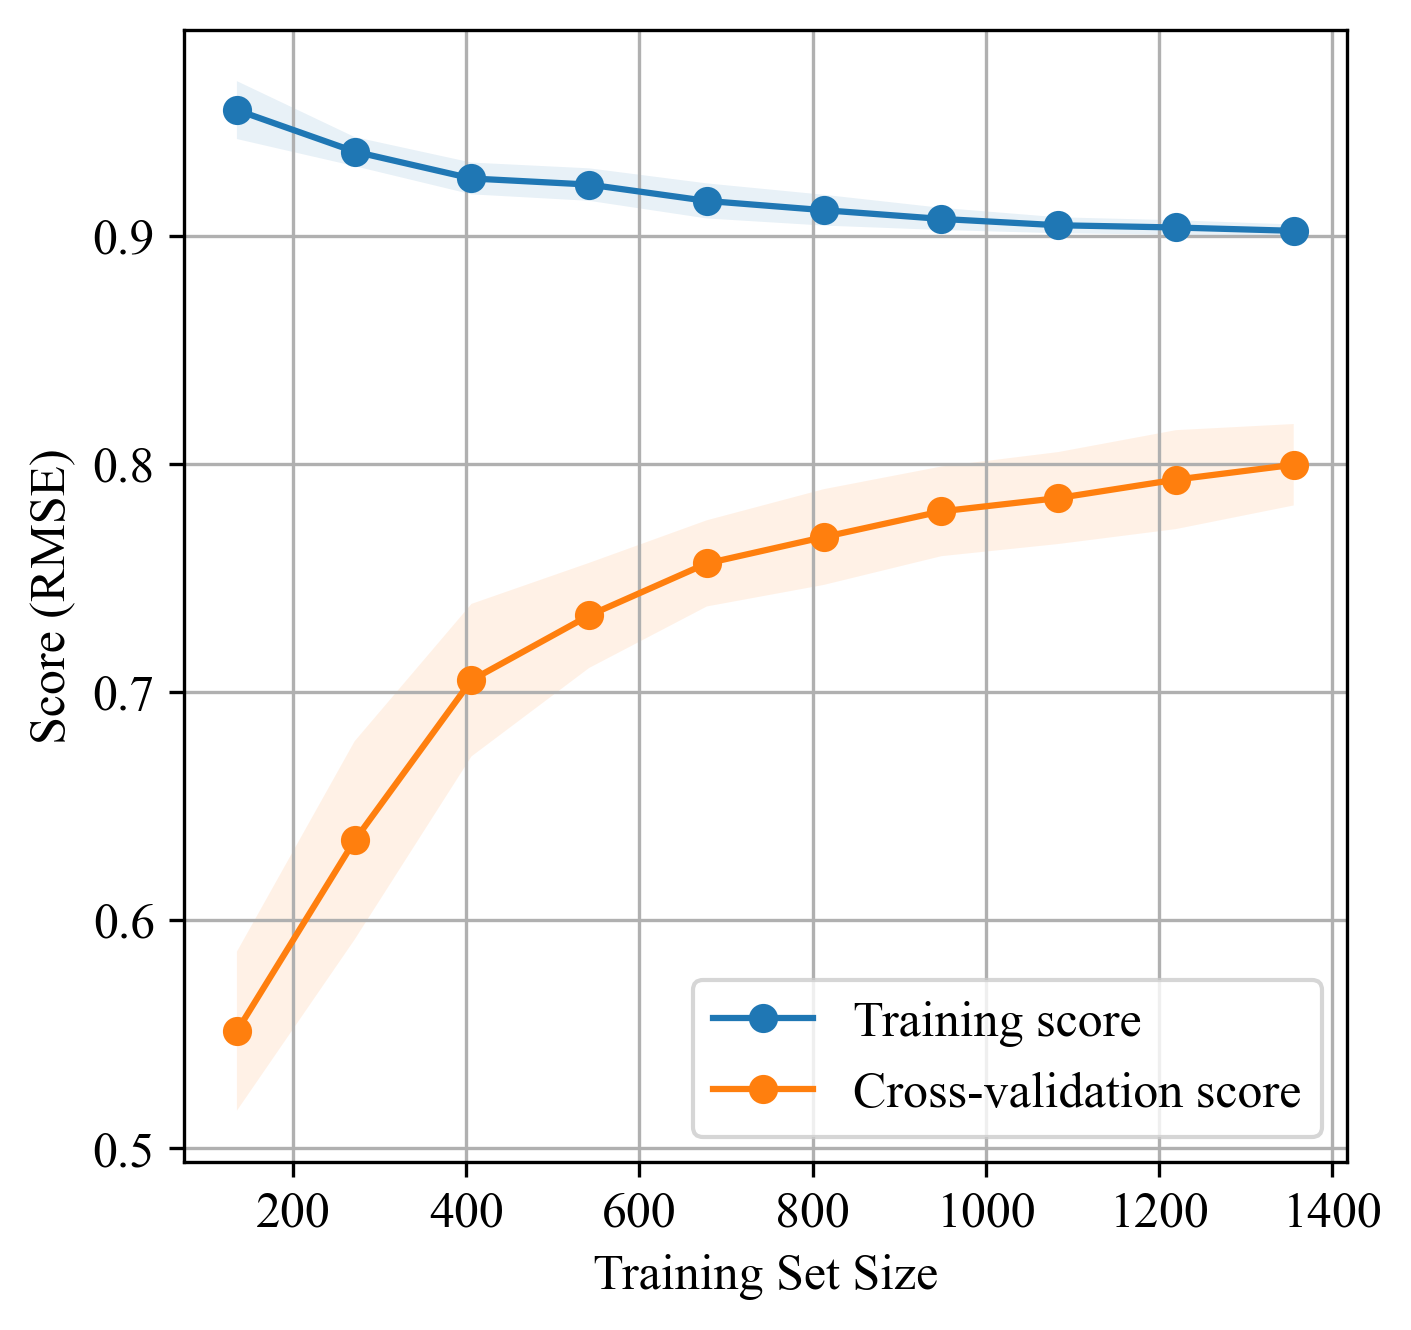

In [177]:
y = df_I[['Life_Satisfaction']]
X = df_I.drop(columns=['Life_Satisfaction', "Country"])
LearningCurves(knn_mod_I, X, y)
#plt.title("Learning Curve - SVC Model (Imputed Data)")
plt.savefig(fname = "Figures/LearnCurve_Imputed.png", dpi = 300)

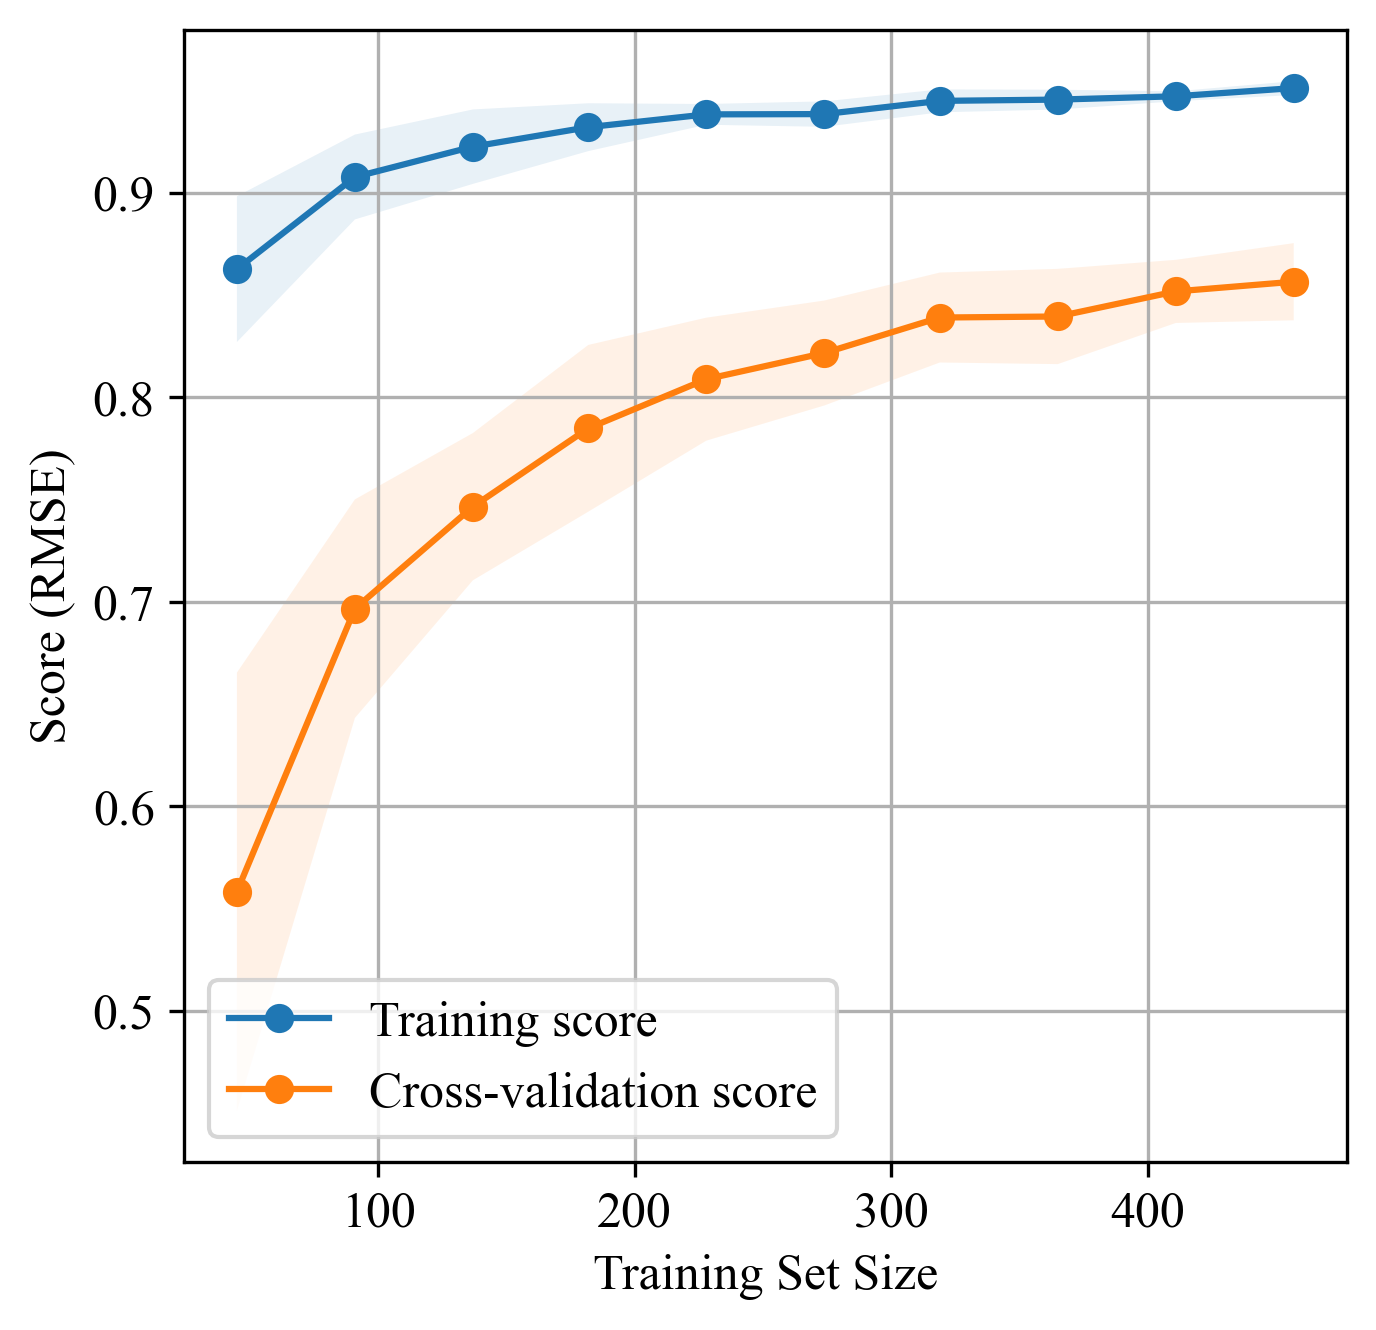

In [180]:
#plt.title("Learning Curve - KNN Model (Union Data)")
y = df_U[['Life_Satisfaction']]
X = df_U.drop(columns=['Life_Satisfaction', "Country"])
LearningCurves(knn_mod_U, X, y)
plt.savefig(fname = "Figures/LearnCurve_Union.png", dpi = 300)

# Interpretation

This will be done mostly using PDPs